In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import interpolate
from scipy import integrate
from scipy.optimize import fsolve

from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from ligo.skymap.io import fits
import healpy as hp

import os
from os import listdir
from os.path import isfile, join

from multiprocessing import Pool
import time
from numba import njit

import sys
from tqdm import tqdm

H0GLOB=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)

In [85]:
#-----------------Functions--------------------------
def z_from_dL(dL_val):
    '''
    Returns redshift for a given luminosity distance dL (in Mpc)'''
    
    func = lambda z :cosmoflag.luminosity_distance(z).value - dL_val
    z = fsolve(func, 0.77)
    return z[0]
def z_from_dcom(dc_val):
    '''
    Returns redshift for a given comoving distance dc (in Mpc)'''
    
    func = lambda z :cosmoflag.comoving_distance(z).value - dc_val
    z = fsolve(func, 0.77)
    return z[0]

def Mises_Fisher(theta,phi,DS_theta,DS_phi,conc):
    meanvec=hp.ang2vec(DS_theta,DS_phi)
    meanvec=np.asarray(meanvec,dtype=np.float128)
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    var=hp.ang2vec(theta,phi)
    var=np.asarray(var,dtype=np.float128)
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    factor=np.dot(conc*var,meanvec)
    factor=np.float128(factor)
    #Normalization is futile, we will devide by the sum
    #fullnorm=conc/(2*np.pi*(np.exp(conc)-np.exp(-conc)))
    ret=np.float128(np.exp(factor))#/fullnorm
    #ret=factor
    return ret

@njit
def sphere_uncorr_gauss(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    #meanvec=(mux,muy)
    meanvec=np.asarray((1,mux,muy))
    norm=np.sqrt(np.sum(meanvec**2))
    meanvec=meanvec/norm
    
    #var=(x,y)
    var=np.asarray((1,x,y))
    #norm=np.sqrt(np.dot(var,var))
    norm=np.sqrt(np.sum(var**2))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.sum(diff**2))
    #xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    #yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))#/norm
    #ret=np.exp(-1/2*(xfactor+yfactor))
    return ret

def beta_line(galaxies,z0,z1,zmax):
    denom=len(galaxies[(galaxies>=z0)*(galaxies<=z1)])
    num=len(galaxies[galaxies<=zmax])
    ret=num/denom
    return ret
def normalisation(galaxies,zmax):
    #is a beta after some simplification with the likelihood
    #cat must be complete, omega must be a constant we set that all to 1
    ret=len(galaxies[galaxies<=zmax])
    return ret

@njit
def likelihood_line(mu,dl,k=0.1):
    sigma=k*mu
    norm=1/(np.sqrt(2*np.pi)*sigma)
    body=np.exp(-((dl-mu)**2)/(2*sigma**2))
    ret=norm*body
    return ret



In [60]:
%%timeit
sphere_uncorr_gauss(0,0,1,1, 0.08, 0.08)

The slowest run took 4.76 times longer than the fastest. This could mean that an intermediate result is being cached.
1.74 µs ± 1.35 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
#-----------------Parameter setting--------------------------------
H0min=55#30
H0max=85#140
H0Grid=np.linspace(H0min,H0max,1000)
nsamp=1500000
z_inf_cat=0.85#0.79
z_sup_cat=1.15#2
dcom_min=cosmoflag.comoving_distance(z_inf_cat).value
dcom_max=cosmoflag.comoving_distance(z_sup_cat).value


dl_min=cosmoflag.luminosity_distance(z_inf_cat).value
dl_max=cosmoflag.luminosity_distance(z_sup_cat).value
betaHomdMax =15978#dl_max#15978.6#(dl_max-dl_min)/2#15978.6#max dl
#---------angular stuff------------------
fisher=0
#------meses-fisher-------------------------
if fisher==1:
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    conc=1/(sigma_phi**2)
    print('Fisher concentration Parameter k={}'.format(conc))
    print('Sigma phi={}°,Sigma theta={}°'.format(sigma_deg,sigma_deg))
else:
    #-----------Gaussian-----------------------------------
    radius_deg= np.sqrt(10/np.pi)
    sigma90=radius_deg/np.sqrt(2)
    sigma_deg=sigma90/1.5
    circle_deg=6*sigma_deg
    sigma_theta=np.radians(sigma_deg)
    sigma_phi=np.radians(sigma_deg)
    radius_rad=np.radians(circle_deg)
    print('Sigma phi={},Sigma theta={}'.format(sigma_phi,sigma_phi))
    print('Sigma phi={}°,Sigma theta={}°'.format(sigma_deg,sigma_deg))


phi_min=0
phi_max=phi_min+5.5*sigma_phi
theta_min=0
theta_max=theta_min+5.5*sigma_theta#depends on the arccos 0 to 1 is from pi/2 to 0 -1 to 1 is full range
print('phi min={},phi Max={}'.format(phi_min,phi_max))
print('theta min={},theta Max={}'.format(theta_min,theta_max))
s=0.1
DS_z=1
DS_phi=(phi_max-phi_min)/2
DS_theta=(theta_max-theta_min)/2

dphi=np.linspace(phi_min,phi_max,1000)
dtheta=np.linspace(theta_min,theta_max,1000)
area=(phi_max-phi_min)*np.trapz(np.sin(dtheta),dtheta)
area=np.trapz(np.sin(dtheta),dtheta)
print('Area in Str={}'.format(area))
fixed_phi=DS_phi
fixed_theta=DS_theta

Sigma phi=0.014678989991133373,Sigma theta=0.014678989991133373
Sigma phi=0.8410441740067199°,Sigma theta=0.8410441740067199°
phi min=0,phi Max=0.08073444495123355
theta min=0,theta Max=0.08073444495123355
Area in Str=0.0032572554759325617


In [62]:
#------------------points generator------------------
u = np.random.uniform(0,1,size=nsamp) # uniform random vector of size nsamp
dc_gals_all     = np.cbrt((u*0**3)+((1-u)*dcom_max**3))
#dc_gals_all     = (u*dcom_min)+(1-u)*dcom_max
phi_gals   = np.random.uniform(phi_min,phi_max,nsamp)
theta_gals = np.arccos( np.random.uniform(np.cos(theta_max),1,nsamp) )
dc_gals=dc_gals_all[dc_gals_all>=dcom_min]
print(len(dc_gals_all),len(dc_gals),len(dc_gals)/len(dc_gals_all))

1500000 726486 0.484324


In [63]:
np.savetxt('Fullcat_dcgals.txt',dc_gals)
np.savetxt('Fullcat_phigals.txt',phi_gals)
np.savetxt('Fullcat_thetagals.txt',theta_gals)

In [64]:
mu=cosmoflag.luminosity_distance(DS_z).value
dc_ds=cosmoflag.comoving_distance(DS_z).value
real_mu=mu
#mu=np.random.normal(real_mu,s*real_mu)
print(dc_ds,real_mu,mu,DS_z)

3413.691357055775 6827.38271411155 6827.38271411155 1


In [65]:
nsamp=5000
new_dc_gals=np.random.choice(dc_gals,nsamp)
new_phi_gals=np.random.choice(phi_gals,nsamp)
new_theta_gals=np.random.choice(theta_gals,nsamp)
z_gals=np.zeros(len(new_dc_gals))
dl_gals=np.zeros(len(new_dc_gals))

for i in range(len(new_dc_gals)):
    z_gals[i]=z_from_dcom(new_dc_gals[i])
    dl_gals[i]=cosmoflag.luminosity_distance(new_dc_gals[i]).value

#----------------DS creation-------------------------------

if not (DS_z in z_gals)*(DS_phi in new_phi_gals)*(DS_theta in new_theta_gals): 
    if not z_gals.size:
        z_gals=np.zeros(1)
        dl_gals=np.zeros(1)
        z_gals[0]=DS_z
        dl_gals[0]=real_mu
        new_phi_gals[0]=DS_phi
        new_theta_gals[0]=DS_theta
        print('size was 0, host added')
    else:
        z_gals=np.append(z_gals,DS_z)
        dl_gals=np.append(dl_gals,real_mu)
        new_phi_gals=np.append(new_phi_gals,DS_phi)
        new_theta_gals=np.append(new_theta_gals,DS_theta)
        print('size was not 0, host added')
np.savetxt('Extractedcat_zgals.txt',z_gals)
np.savetxt('Extractedcat_dcgals.txt',new_dc_gals)
np.savetxt('Extractedcat_phigals.txt',new_phi_gals)
np.savetxt('Extractedcat_thetagals.txt',new_theta_gals)

size was not 0, host added


# Testing our distributions

In [66]:
#-----------------test the uniform distribution
position=[]
volume=[]
numobj=[]

Nbis=15
step=(np.max(dc_gals_all)-np.min(dc_gals_all))/Nbis
start=np.min(dc_gals_all)
for i in range(Nbis):
    dcsup=step/2 +start+(step)*i
    position.append(dcsup)
    tmp=dc_gals_all[dc_gals_all<dcsup]
    numobj.append(len(tmp))
    volume.append(dcsup**3)
position=np.asarray(position)
volume=np.asarray(volume)
numobj=np.asarray(numobj)
volume=volume/np.min(volume)
norm=numobj[0]
volume=volume*norm

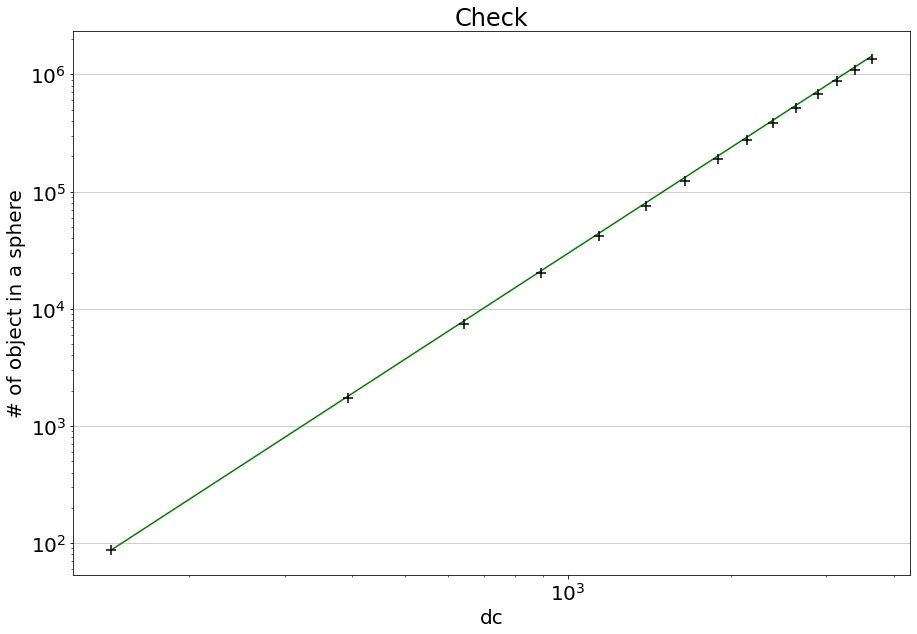

In [67]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,10))
#n, bins, patches = plt.hist(x=numobj,grid=True, bins=Num, rwidth=0.9,color='#607c8e')
plt.xscale('log')
plt.yscale('log')
plt.title('Check')
plt.scatter(position,numobj,s=100, marker='+', c='k', zorder=10 )
plt.plot(position,volume,color='g')
plt.xlabel('dc')
plt.ylabel('# of object in a sphere')
plt.grid(axis='y', alpha=0.75)

Text(0.5, 1.0, 'Phi Dist')

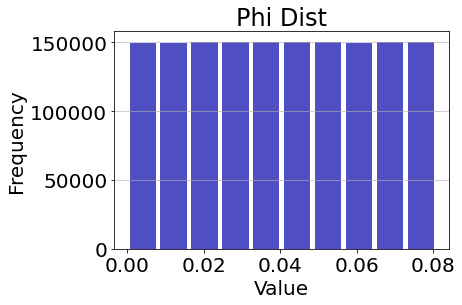

In [68]:
n, bins, patches = plt.hist(x=phi_gals, bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Phi Dist')

Text(0.5, 1.0, 'Cos Theta dist')

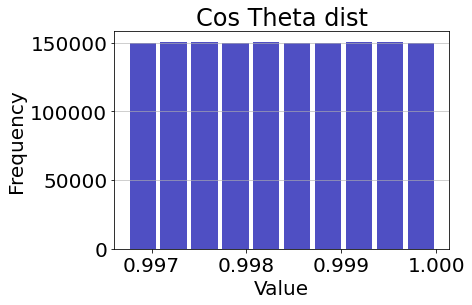

In [69]:
n, bins, patches = plt.hist(x=np.cos(theta_gals), bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Cos Theta dist')

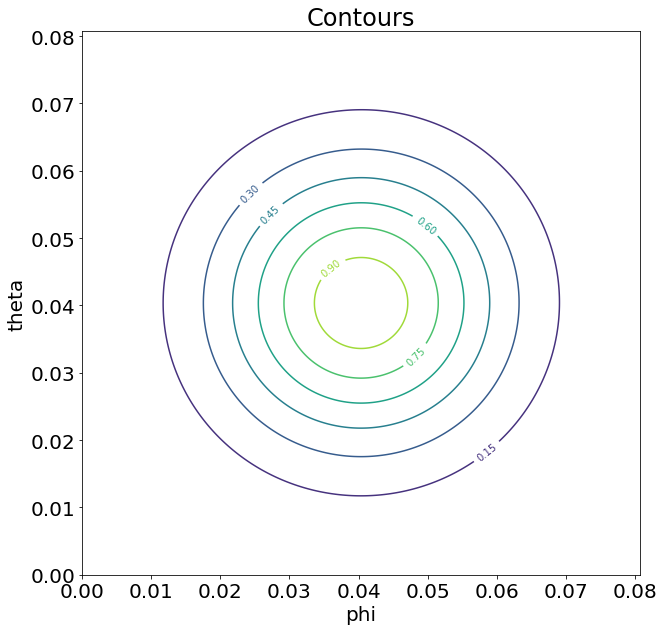

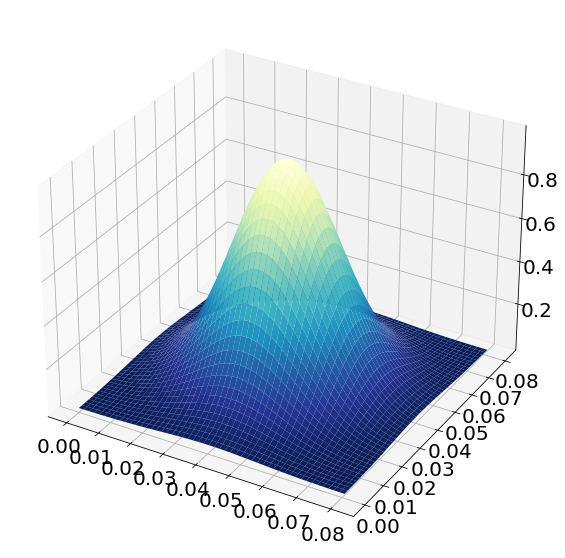

In [70]:
#------------Mises_Fisher-----------------
import matplotlib.cm as cm
point=500

theta_test=np.linspace(theta_min,theta_max,point)
phi_test=np.linspace(phi_min,phi_max,point)
values=np.float128(np.zeros((point,point)))
for i in range(point):
    for j in range(point):
        values[i,j]=sphere_uncorr_gauss(phi_test[i],theta_test[j],DS_phi,DS_theta,sigma_phi,sigma_theta)
X,Y=np.meshgrid(phi_test,theta_test)
Z=values
fig, ax = plt.subplots(1,figsize=(10,10))
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Contours')
ax.set_xlabel('phi')
ax.set_ylabel('theta')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)


In [71]:
@njit
def E_z(z, H0, Om):
    return np.sqrt(Om*(1+z)**3+(1-Om))

In [72]:
%%timeit
E_z(3, 67, 0.3)

202 ns ± 0.127 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [73]:
def r_z(z, H0, Om):
    c = 299792.458
    integrand = lambda x : 1/E_z(x, H0, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return c/H0*integral

In [74]:
def Dl_z(z, H0, Om):
    return r_z(z, H0, Om)*(1+z)

In [75]:
%%timeit
r_z(3,67, 0.3)

9.2 µs ± 10.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [76]:
%%timeit
Dl_z(3, 67, 0.3)

9.36 µs ± 29.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


# Computing the likelihood

$$
 L(D_{gw}|H_0)=\frac{1}{\sum_{z_{\alpha}<z_{max} }\omega_{\alpha}}\sum_{\alpha}^{N(R)}\omega_{\alpha}\frac{\rho}{\sqrt{2\pi}\sigma}e^{-\frac{(dl_{\alpha}-\mu)^2}{2\sigma^2}}
$$
$$
\omega_{\alpha}=1; \forall\alpha\,\, \rho=1
$$

In [77]:
arr=np.arange(0,len(H0Grid),dtype=int)
beta=np.zeros(len(H0Grid))
My_Like=np.zeros(len(H0Grid))


In [78]:
%%timeit
FlatLambdaCDM(H0=67, Om0=Om0GLOB).luminosity_distance(3)

590 µs ± 835 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [79]:
print(DS_z)

1


In [82]:
def LikeofH0(iterator):
    i=iterator
    Htemp=H0Grid[i]
    #norm=integrate.quad(lambda x:  FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB).differential_comoving_volume(x).value, 0, 10 )[0]
    #----------computing sum
    to_sum=np.zeros(len(z_gals))
    for j in range(len(z_gals)):
        #dl=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB).luminosity_distance(z_gals[j]).value
        dl = Dl_z(z_gals[j], Htemp, Om0GLOB)
        angular_prob=sphere_uncorr_gauss(new_phi_gals[j],new_theta_gals[j],DS_phi,DS_theta,sigma_phi,sigma_theta)
        to_sum[j]=likelihood_line(mu,dl,s)*angular_prob#*norm
    tmp=np.sum(to_sum)#*norm
    return tmp

def multibeta(iterator):
    i=iterator
    Htemp=H0Grid[i]
    cosmo=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB)
    func = lambda z :cosmo.luminosity_distance(z).value - betaHomdMax
    zmax = fsolve(func, 0.8)[0]
    Num=normalisation(z_gals,zmax)
    if Num==0:
        Num=Num+1
    return Num

def vol_beta(iterator):
    i=iterator
    Htemp=H0Grid[i]
    cosmo=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB)
    func = lambda z :cosmo.luminosity_distance(z).value - betaHomdMax
    zMax = fsolve(func, 0.80)[0]        
    norm = integrate.quad(lambda x: cosmo.differential_comoving_volume(x).value,0,10)[0]
    num = integrate.quad(lambda x:cosmo.differential_comoving_volume(x).value,0,zMax)[0]
    return num/norm

In [87]:
start_time = time.time()
s=0.1 #to do mixed runs
print('sigma is set to {}'.format(s))
print('I am Doing my best, please wait...')
with Pool(14) as p:
    My_Like=p.map(LikeofH0, arr)
    beta=p.map(vol_beta, arr)
print("--- %s seconds ---" % (time.time() - start_time))
My_Like=np.asarray(My_Like)
beta=np.asarray(beta)

sigma is set to 0.1
I am Doing my best, please wait...
--- 15.030490636825562 seconds ---


In [ ]:
Beta=interpolate.CubicSpline(H0Grid,beta)

In [ ]:
xmin=float(H0Grid[0])
xmax=float(H0Grid[-1])
x=H0Grid
href=67
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlabel(r'$H_0$', fontsize=15)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Likelihood$', fontsize=20)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
#ax.axhline(y=np.max(My_Like)/np.trapz(My_Like,x),color = 'k', linestyle='dashdot')
ax.plot(x,(My_Like/1)/np.trapz(My_Like/1,x),label='10% uncertainty',color='#671D5B',
        linestyle='solid',linewidth=3)
#ax.set_ylabel(r'$Beta$', fontsize=20)
#ax.set_xscale('log')
#ax.set_yscale('log')
#data_path='/home/rciancarella/DarkSirensStat/results/GW33_Enzo_sig10samesig_11/'
#os.chdir(data_path)
#xx=np.loadtxt('H0_grid.txt')#x
#event='GW330320'
#bbeta=np.loadtxt(event+'_betaH0.txt')
#ax.plot(x,Beta(x)/Beta(x[0]),label='10% uncertainty',color='#004b49',
#        linestyle='solid',linewidth=3)
#ax.plot(xx,bbeta/bbeta[0],label='10% uncertainty',color='#17EA1E',
#        linestyle='solid',linewidth=3)
#Nice-colours:
#671D5B---violet
#004b49---dark petrol
#17EA1E---Eva01 green

In [ ]:
dist=(My_Like/beta)/np.trapz(My_Like/beta,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
#std=np.sqrt(np.sum((My_Like-mean)**2)/len(My_Like))
#alltest=[]
alltest.append(dist)

In [ ]:
print('mean={},std={}'.format(mean,std))

In [ ]:
combined=[]
xmin=float(H0Grid[0])
xmax=float(H0Grid[-1])
x=H0Grid
href=67
colors=pl.cm.turbo(np.linspace(0.01,0.99,2*len(alltest)))
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlabel(r'$H_0$', fontsize=15)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Likelihood$', fontsize=20)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
#ax.axhline(y=np.max(My_Like)/np.trapz(My_Like,x),color = 'k', linestyle='dashdot')
for i in range(len(alltest)):
    #combined=combined+post[i]
    if i==0:
        tmp=np.trapz(alltest[i],x)
        combined.append(alltest[i]/tmp)
    else:
        tmp=np.float128((combined[i-1]+alltest[i])/2)
        norm=1#np.trapz(tmp,x)
        combined.append(tmp/norm)
    ax.plot(x,combined[i]/np.trapz(combined[i],x),label='# runs'+str(i+1),color=colors[i],
        linestyle='solid',linewidth=3)
ax.plot(x,combined[-1]/np.trapz(combined[-1],x),color='k',
    linestyle='dashdot',linewidth=3)
ax.legend(fontsize=12,ncol=1)

In [ ]:
allmax=np.zeros(len(alltest))
for i in range(len(alltest)):
    allmax[i]=np.max(combined[i]/np.trapz(combined[i],x))
x_run=np.linspace(1,len(alltest),len(alltest))
#print(x_run)
import matplotlib.pyplot as plt

coef = np.polyfit(x_run,allmax,2)
poly1d_fn = np.poly1d(coef) 


In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlabel(r'$run$', fontsize=15)
ax.set_ylabel(r'$eight$', fontsize=15)
ax.scatter(x_run,allmax)
ax.plot(x_run, poly1d_fn(x_run), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker

In [ ]:
save=0
if save==1:
    res_path='/home/rciancarella/DarkSirensStat/ProxyGenerator'
    os.chdir(res_path)
    np.savetxt('new_Post_sigma10.txt',dist)
    #np.savetxt('myh0grid.txt',x)

# More DS

In [88]:
#----------------DS extraction-----------------------------
NumDS=10
s=0.1
z_pool=z_gals[z_gals<1.07]
z_pool=z_pool[z_pool>0.93]
print(len(z_pool))
phi_pool=new_phi_gals[new_phi_gals<fixed_phi+1*sigma_phi]
phi_pool=phi_pool[phi_pool>fixed_phi-1*sigma_phi]
print(len(phi_pool))
theta_pool=new_theta_gals[new_theta_gals<fixed_theta+1*sigma_theta]
theta_pool=theta_pool[theta_pool>fixed_theta-1*sigma_theta]
print(len(theta_pool))

#z_gals=np.linspace(0.95,1.05,NumDS)
#dl_gals=cosmoflag.luminosity_distance(z_gals).value
#new_phi_gals=np.ones(NumDS)*fixed_phi
#new_theta_gals=np.ones(NumDS)*fixed_theta


2252
1840
1795


In [89]:
fullrun=[]
for k in tqdm(range(NumDS)):
    #print(k)
    DS_z=np.random.choice(z_pool,1)[0]
    DS_phi=np.random.choice(phi_pool,1)[0]
    DS_theta=np.random.choice(theta_pool,1)[0]

    mu=cosmoflag.luminosity_distance(DS_z).value
    #dc_ds=cosmoflag.comoving_distance(DS_z).value
    #real_mu=mu
    if k==0:
        with Pool(14) as p:
            My_Like=p.map(LikeofH0, arr)
            beta=p.map(vol_beta, arr)
        My_Like=np.asarray(My_Like)
        beta=np.asarray(beta)
    else:
        with Pool(14) as p:
            My_Like=p.map(LikeofH0, arr)
        My_Like=np.asarray(My_Like)
    fullrun.append(My_Like)

100%|█████████████████████████████████████████████████████████████████████████| 10/10 [02:01<00:00, 12.12s/it]


In [107]:
fullrun_beta=fullrun/beta

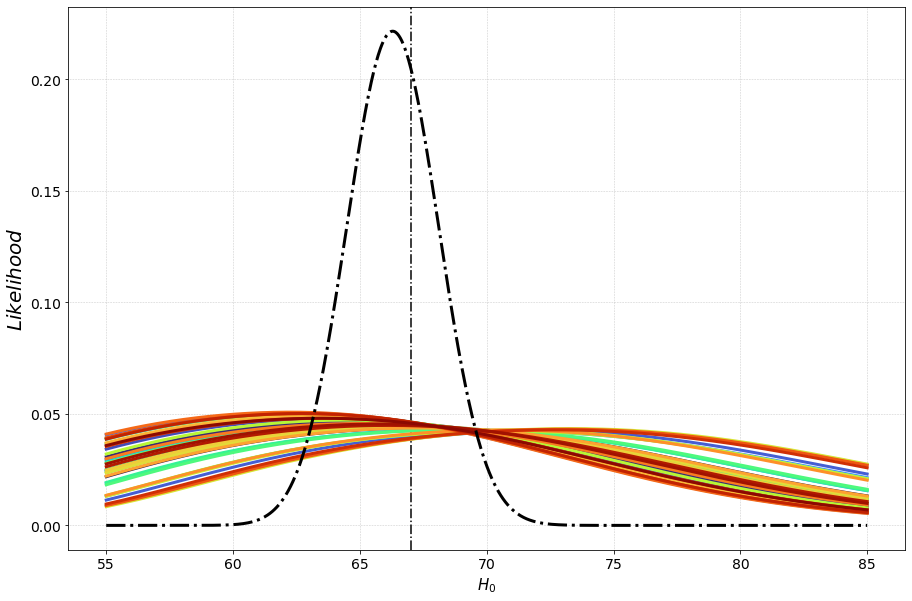

In [112]:
xmin=float(H0Grid[0])
xmax=float(H0Grid[-1])
x=H0Grid
href=67
combined=[]
colors=pl.cm.turbo(np.linspace(0.01,0.99,2*len(fullrun_beta)))
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlabel(r'$H_0$', fontsize=15)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax.set_ylabel(r'$Likelihood$', fontsize=20)
if xmin<href<xmax:
    ax.axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
#ax.axhline(y=np.max(My_Like)/np.trapz(My_Like,x),color = 'k', linestyle='dashdot')
#ax.plot(x,(fullrun[2]/1)/np.trapz(fullrun[2]/1,x),label='10% uncertainty',color='#671D5B',
#        linestyle='solid',linewidth=3)
for i in range(len(fullrun_beta)):
    #combined=combined+post[i]
    if i==0:
        combined.append(fullrun_beta[i]*1)
    else:
        num=np.float128(combined[i-1]*(fullrun_beta[i]*1))
        combined.append(num)
    ax.plot(x,fullrun_beta[i]/np.trapz(fullrun_beta[i],x),label='# runs'+str(i+1),color=colors[2*i],linestyle='solid',linewidth=3)
ax.plot(x,combined[-1]/(np.trapz(combined[-1],x)),color='k',linestyle='dashdot',linewidth=3)
#ax.plot(x,test,color='g',linestyle='solid',linewidth=3)
#ax.set_ylabel(r'$Beta$', fontsize=20)
#ax.set_xscale('log')
#ax.set_yscale('log')
#data_path='/home/rciancarella/DarkSirensStat/results/GW33_Enzo_sig10samesig_11/'
#os.chdir(data_path)
#xx=np.loadtxt('H0_grid.txt')#x
#event='GW330320'
#bbeta=np.loadtxt(event+'_betaH0.txt')
#ax.plot(x,Beta(x)/Beta(x[0]),label='10% uncertainty',color='#004b49',
#        linestyle='solid',linewidth=3)
#ax.plot(xx,bbeta/bbeta[0],label='10% uncertainty',color='#17EA1E',
#        linestyle='solid',linewidth=3)
#Nice-colours:
#671D5B---violet
#004b49---dark petrol
#17EA1E---Eva01 green

In [113]:
dist=(combined[-1]/1)/np.trapz(combined[-1]/1,x)
mean=np.trapz(x*dist,x)/np.trapz(dist,x)
std=np.sqrt(np.trapz(dist*(x-mean)**2,x)/np.trapz(dist,x))
#std=np.sqrt(np.sum((My_Like-mean)**2)/len(My_Like))
print('mean={},std={}'.format(mean,std))

mean=66.30194839091575,std=1.7911137907794876


In [114]:
#store= fullrun_beta
#store01=fullrun_beta
#store02=fullrun_beta
#store03=fullrun_beta
#np.savetxt('runSig10_03.txt',store03)
np.savetxt('4runSig10.txt',fullrun_beta)

In [111]:
fullrun_beta=np.append(fullrun_beta,store02,axis=0)

In [104]:
np.shape(fullrun_beta)

(40, 1000)

In [92]:
betaHomdMax =dl_max#15978#dl_max
with Pool(14) as p:
    betanew=p.map(vol_beta, arr)
betanew=np.asarray(betanew)

In [76]:
np.shape(beta)

(1000,)

In [96]:
#store02=store02*betanew/beta

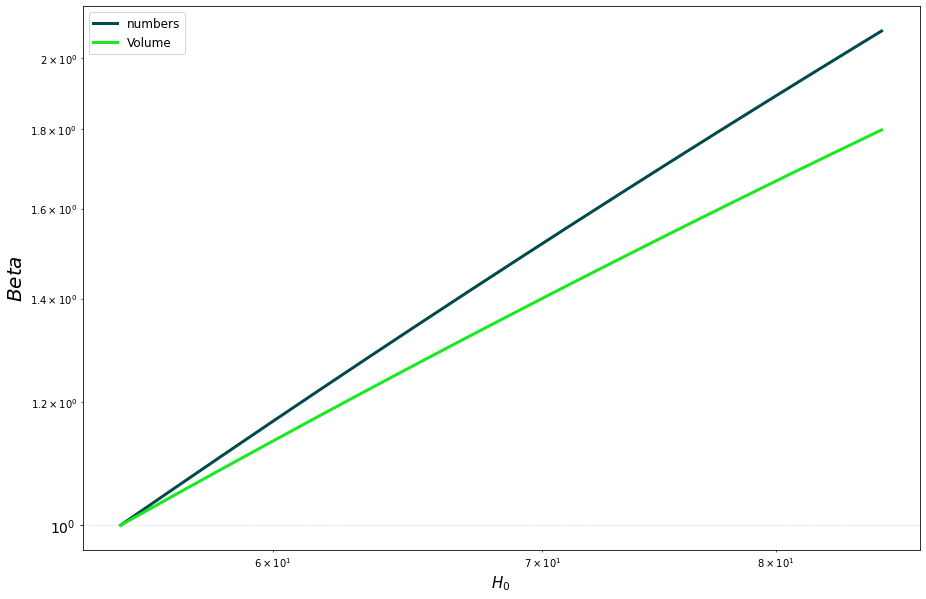

In [93]:
xmin=float(H0Grid[0])
xmax=float(H0Grid[-1])
x=H0Grid
href=67
combined=[]
colors=pl.cm.turbo(np.linspace(0.01,0.99,2*len(fullrun_beta)))
fig, ax = plt.subplots(1, figsize=(15,10)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax.set_xlabel(r'$H_0$', fontsize=15)
ax.set_ylabel(r'$Beta$', fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(x,betanew/betanew[0],label='numbers',color='#004b49',
        linestyle='solid',linewidth=3)
ax.plot(x,beta/beta[0],label='Volume',color='#17EA1E',
        linestyle='solid',linewidth=3)
ax.legend(fontsize=12,ncol=1)

In [66]:
betanew[0]

0.04233542496178604

In [67]:
beta[0]

0.04233542496178604